In [2]:
import sys
sys.path.append('./code')
from initialize import *

%load_ext autoreload

treg_250kb = cooler.Cooler('./Treg_all.mcool::/resolutions/250000')


(chromsizes, parsed_chroms, region_to_inds, 
    all_region_to_ind, inds_to_region, all_ind_to_region, 
    chrom_to_start, chrom_to_end) = initialize_helper_vars(treg_250kb)

In [3]:
from aux_functions import *
from hichip_volcanoes import *

import initialize
from initialize import *
from mpl_toolkits import axes_grid1
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [4]:
def save_plot_with_coolbox(i1, i2, d1, d2, end='svg', vmin=1e-5, vmax=5e-3):
    ind1, ind2 = (i1-d1, i1+d1), (i2-d2, i2+d2+1)
    fig_tcon = plot_off_diag_with_coolbox(ind1, ind2, frame2=tcon_frame2, coolpath='./Tconv_all.mcool', vmin=vmin, vmax=vmax)
    fig_tcon.save(f"./plots/fig2_all_intra/offdiag_{i1}_{i2}_h3k27me3_tcon.{end}")


    fig_treg = plot_off_diag_with_coolbox(ind1, ind2, frame2=treg_frame2, coolpath='./Treg_all.mcool', vmin=vmin, vmax=vmax)
    fig_treg.save(f"./plots/fig2_all_intra/offdiag_{i1}_{i2}_h3k27me3_treg.{end}")
    return fig_treg, fig_tcon

In [5]:
import inspect


import inspect


def plot_off_diag_with_coolbox(ind1, ind2, coolpath='./Treg_all.mcool', 
                               outdir='./plots/', frame2=None, vmin = 1e-5, vmax=5e-3,):

    
    # frame1 += BigWig(f"{DATA_DIR}/bigwig_{test_itv}.bw") + TrackHeight(2) + MinValue(0)
    if frame2 is None:
        frame2 = XAxis()
        frame2 += GTF(f"annotations/gencode_mm10.gtf") + TrackHeight(5)

    cool1 = HiCMat(coolpath, balance=True, cmap='gist_heat_r', 
                    resolution=50_000, #gaussian_sigma = .5,
                  min_value = vmin, max_value = vmax, transform=None,
                )

    sub_frames = {
    #     "top": frame1,
    #     "right": frame1,
        "bottom": frame2,
        "right": frame2
    }

    chrom1, s1, _ = all_ind_to_region[ind1[0]]
    chrom1, _, e1 = all_ind_to_region[ind1[1]]

    chrom2, s2, _ = all_ind_to_region[ind2[0]]
    chrom2, _, e2 = all_ind_to_region[ind2[1]]
    jv = JointView(cool1, **sub_frames, space=0, padding_left=0)
    fig = jv.plot(f"chr{chrom1}:{s1}-{e1}", f"chr{chrom2}:{s2}-{e2}")
    return fig

In [6]:
def make_coolbox_plot(d1=3, d2 = 3, i1 = 278, i2 = 278, depth_ratio = .45, 
                      treg_coolpath = '/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/zoomified_merged_cools/Rename_Treg_all_no_chrM.mcool',
                      tcon_coolpath = '/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/zoomified_merged_cools/Rename_Tconv_all_no_chrM.mcool', 
                      gtf_ylim=[-1, 1],
                      **kwargs):
    f, Lanc, Ranc = save_plot_with_coolbox_diag(i1, d1, d2, all_ind_to_region, cools_frame, end='svg', ctcf_paths=ctcf_path_dict,
                                                treg_coolpath = treg_coolpath,
                                                tcon_coolpath = tcon_coolpath,
                                                depth_ratio=depth_ratio,  **kwargs)
    chrom1, L, R = Lanc
    
    span = R - L
    gtf_ax_ind = find_gtf_ax(f)
    
    
    for c, text in enumerate(f.axes[gtf_ax_ind].texts):
        text.remove()
    #     pos = text.get_position()
    #     x = pos[0]
    #     y = pos[1]
    # #         print(x, pos, text)Z
    #     if x < L:
    #         x = text.set_position([L+span//10, y])
    #     elif x > R:
    #         x = text.set_position([R-span//10, y])
    #     else:
    #             text.set_position([x, y*.5])
        
    for p in f.axes[gtf_ax_ind].lines:
        # ys = p.get_xydata()[:, 1]
        # p.set_ydata(ys*.5)
        p.remove()

    for p in f.axes[gtf_ax_ind].patches:
        p.remove()
        # pass

    place = (chrom1, L, R)
    plot_one_GTF_on_axis(place, ax=f.axes[gtf_ax_ind], scilim=False, ignore_set = ['Ankrd16', 'Fbxo18', 'AC154412.1'],
                        gene_name_fontsize=4, skip_gm=True, skip_rik=True)

    ticks = list(f.axes[4].get_xlim())
    s, e = ticks[0], ticks[-1]
    ticks = [int(s), int(s+e)//2, int(e)]
    print(ticks)
    f.axes[4].set_xticks(ticks)    
    f.axes[4].set_xticklabels(['{:,}'.format(x) for x in ticks])
    f.axes[gtf_ax_ind].set_ylim(gtf_ylim)
    # for p in f.axes[gtf_ax_ind].lines:
    #     # ys = p.get_xydata()[:, 1]
    #     # p.set_ydata(ys*.5)
    #     p.remove()
    # for p in f.axes[gtf_ax_ind].patches:
        # p.remove()
        # pass
    
    # # return f.axes[gtf_ax_ind]
    for ax in find_ctcf_axes(f):
        for patch in f.axes[ax].patches:
            xy = patch.get_xy()
            xs, counts = np.unique(xy[:, 0], return_counts=True)
            delta = (xs[counts==1] - xs[counts==2])
            xy[:, 0][xy[:, 0] == xs[counts==1]] += delta*2
            patch.set_xy(xy)

    for ax in f.axes:
        for i in ax.texts:
            if ('Treg' in i.get_text()) or ('Tcon' in i.get_text()) or ('KO' in i.get_text()):
                i.set_fontsize(14)
            if ('CTCF' in i.get_text()):
                i.set_fontsize(14)
            if ('Hi-C' in i.get_text()):
                i.set_fontsize(16)
            if ('Genes' in i.get_text()):
                i.set_fontsize(16)
    f.axes[1].get_xticks()
    return f


def find_ctcf_axes(f):
    ctcf_axes = []
    for _, ax in enumerate(f.axes):
        for c, text in enumerate(ax.texts):
            if 'CTCF Motif' in text.get_text():
                ctcf_axes.append(_-1)
    return ctcf_axes

def find_gtf_ax(f):
    for _, ax in enumerate(f.axes):
        for c, text in enumerate(ax.texts):
            if 'Genes' in text.get_text():
                return _-1


In [7]:
%load_ext autoreload
%autoreload 2
from coolbox.api import *
from plot_with_coolbox import *
from plotting_functions import *

cutrun_pref = '../../snakemake_sras/cutrun_bws/'
bw_pref = '../../snakemake_sras/bws/'
titles = {
    "H3K27ac (Treg)" : [bw_pref + '/GSM.SRR5385344.H3K27ac_ChIP-seq_of_Treg_replicate_2.bw', 60, 0, 'red'],
    "H3K27ac (Tcon)" : [bw_pref + '/GSM.SRR5385346.H3K27ac_ChIP-seq_of_Tconv_replicate_2.bw', 60, 0, 'blue'],
    "H3K27me3 (Treg)" : [bw_pref + '/GSM.SRR5385317.H3K27me3_ChIP-seq_of_Treg.bw', 5, 0, 'red'],
    "H3K27me3 (Tcon)" : [bw_pref + '/GSM.SRR5385318.H3K27me3_ChIP-seq_of_Tconv.bw', 5, 0, 'blue'],
    "Foxp3 CUT&RUN (Treg)" : [cutrun_pref + 'GSM4677034.SRR12264676._Foxp3_CUTRUN_bulk_Treg_rep1__Mus_musculus__OTHER.bw', 15, 0, 'red'],
    # 
    # "Stat5 (Treg)" : [bw_pref + '../../snakemake_sras/bws/GSM.DRR277310.901R3a_Stat5ChIP_Treg_periphery_WT_rep3.fastq.bw', 30, 0, 'red'],
    # "Stat5 (Tcon)" : [bw_pref + '../../snakemake_sras/bws/GSM.DRR277304.901C3_Stat5ChIP_Tconv_periphery_WT_rep3.fastq.bw', 30, 0, 'blue'],
    "CTCF (Treg)" : [bw_pref + '../../snakemake_sras/bws/JesseYe.NA.Treg_CTCF_ChIP.bw', 12, 0, 'red'],
    "CTCF (Tcon)" : [bw_pref + '../../snakemake_sras/bws/JesseYe.NA.CD4_Tcell_CTCF_ChIP.bw', 12, 0, 'blue'],
    "Smc1a (Treg)" : [bw_pref + '../../snakemake_sras/bws/GSM.SRR5385276.Smc1a_ChIP-seq_of_Treg.bw', 20, 0, 'red'],
    "Smc1a (Tcon)" : [bw_pref + '../../snakemake_sras/bws/GSM.SRR5385277.Smc1a_ChIP-seq_of_Tconv.bw', 20, 0, 'blue'],
    
    # "Yuri Treg" : [bw_pref + 'GSM3430735.SRR8060923._Foxp3_ChIP-seq_in_Foxp1+_Treg__rep1__Mus_musculus__ChIP-Seq.bw', 4, 0, 'red'],
    # "Yuri Treg 2" : [bw_pref + 'GSM3430736.SRR8060924._Foxp3_ChIP-seq_in_Foxp1+_Treg__rep2__Mus_musculus__ChIP-Seq.bw', 4, 0, 'red'],
    # "Yuri Tcon" : [bw_pref + 'GSM3430740.SRR8060928._Foxp3_ChIP-seq_in_Foxp1+_conventional_T_cells__rep1__genetic_control___Mus_musculus__ChIP-Seq.bw', 4, 0, 'red'],
    # "Yuri Tcon 2" : [bw_pref + 'GSM3430741.SRR8060929._Foxp3_ChIP-seq_in_Foxp1+_conventional_T_cells__rep2__genetic_control___Mus_musculus__ChIP-Seq.bw', 4, 0, 'red'],
    # "Foxp3 3" : [bw_pref + 'GSM999180.SRR561495._Treg_Foxp3_ChIP_Rep1__Tech_Rep2___Mus_musculus__ChIP-Seq.bw', 4, 0, 'red'],
    "H3K9me3 (Tcon)" : [bw_pref + 'GSM2827228.SRR6197767._H3K9me3_WT__Mus_musculus__ChIP-Seq.bw', 4, 0, 'blue'],
    
    # 'Treg1' : [bw_pref + 'GSM4677031.SRR12264673._Foxp3_ChIP-seq_bulk_Treg_rep1__Mus_musculus__ChIP-Seq.bw', 4, 0, 'red'],
    # 'Treg2' : [bw_pref + 'GSM4677032.SRR12264674._Foxp3_ChIP-seq_bulk_Treg_rep2__Mus_musculus__ChIP-Seq.bw', 4, 0, 'red'],
    # 'Treg3' : [bw_pref + 'GSM4677033.SRR12264675._Foxp3_ChIP-seq_bulk_Treg_rep3__Mus_musculus__ChIP-Seq.bw', 4, 0, 'red'],
    'Satb1 (Treg)' : ['../../snakemake_sras/bws//GSM.SRR5385295.Satb1_ChIP-seq_of_Treg.bw', 10, 0, 'red'],
    'Satb1 (Tcon)' : ['../../snakemake_sras/bws//GSM.SRR5385263.Satb1_ChIP-seq_of_peripheral_Tconv.bw', 10, 0, 'blue'],

    
}

# ctcf_path_dict = {
#             'p=1e-05' : 'peaks/motifs/all_ctcf_peaks_p=1e-05.txt',
#             'p=1e-06' : 'peaks/motifs/all_ctcf_peaks_p=1e-06.txt',
#             # 'p=1e-08' : 'peaks/motifs/all_ctcf_peaks_p=1e-08.txt',
# }

ctcf_path_dict = {
            'p=1e-05' : 'peaks/motifs/all_ctcf_peaks_p=1e-05.txt',
}


cools_frame = (GTF(f"annotations/no_gm_gencode_mm10.gtf", fontsize=20) + TrackHeight(1) + Title("Genes"))
for title, (bigwig_path, maxvalue, minvalue, color) in titles.items():
    cools_frame += (BigWig(bigwig_path, style='fill', height = .5, color=color,)
                    + MinValue(minvalue) + MaxValue(maxvalue) 
                    + Title(title) + Spacer(.2)
                   )


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
plt.rcParams['pdf.fonttype'] = 42


In [9]:
def make_coolbox_plot(d1=3, d2 = 3, i1 = 278, i2 = 278, depth_ratio = .45, 
                      treg_coolpath = '/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/zoomified_merged_cools/Rename_Treg_all_no_chrM.mcool',
                      tcon_coolpath = '/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/zoomified_merged_cools/Rename_Tconv_all_no_chrM.mcool', 
                      gtf_ylim=[-1, 1],
                      **kwargs):
    f, Lanc, Ranc = save_plot_with_coolbox_diag(i1, d1, d2, all_ind_to_region, cools_frame, end='svg', ctcf_paths=ctcf_path_dict,
                                                treg_coolpath = treg_coolpath,
                                                tcon_coolpath = tcon_coolpath,
                                                depth_ratio=depth_ratio,  **kwargs)
    chrom1, L, R = Lanc
    
    span = R - L
    gtf_ax_ind = find_gtf_ax(f)
    print(gtf_ax_ind)
    
    for c, text in enumerate(f.axes[gtf_ax_ind].texts):
        text.remove()
    #     pos = text.get_position()
    #     x = pos[0]
    #     y = pos[1]
    # #         print(x, pos, text)Z
    #     if x < L:
    #         x = text.set_position([L+span//10, y])
    #     elif x > R:
    #         x = text.set_position([R-span//10, y])
    #     else:
    #             text.set_position([x, y*.5])
        
    for p in f.axes[gtf_ax_ind].lines:
        # ys = p.get_xydata()[:, 1]
        # p.set_ydata(ys*.5)
        p.remove()

    for p in f.axes[gtf_ax_ind].patches:
        p.remove()
        # pass

    place = (chrom1, L, R)
    gtf_ax = plot_one_GTF_on_axis(place, ax=f.axes[gtf_ax_ind], scilim=False, ignore_set = ['Ankrd16', 'Fbxo18', 'AC154412.1'],
                        gene_name_fontsize=4, skip_gm=True, skip_rik=True)
    ticks = list(f.axes[4].get_xlim())
    s, e = ticks[0], ticks[-1]
    ticks = [int(s), int(s+e)//2, int(e)]
    print(ticks)
    f.axes[4].set_xticks(ticks)    
    f.axes[4].set_xticklabels(['{:,}'.format(x) for x in ticks])

    gtf_ax.set_ylim(gtf_ylim)
    gtf_ax.set_xlim(f.axes[gtf_ax_ind].get_xlim())
    gtf_ax.spines['left'].set_visible(False)
    gtf_ax.spines['bottom'].set_visible(False)
    gtf_ax.set_xlabel("")
    gtf_ax.set_xticks([])
    
    
    
    # # return f.axes[gtf_ax_ind]
    for ax in find_ctcf_axes(f):
        for patch in f.axes[ax].patches:
            xy = patch.get_xy()
            xs, counts = np.unique(xy[:, 0], return_counts=True)
            delta = (xs[counts==1] - xs[counts==2])
            xy[:, 0][xy[:, 0] == xs[counts==1]] += delta*2
            patch.set_xy(xy)

    for ax in f.axes:
        for i in ax.texts:
            if ('Treg' in i.get_text()) or ('Tcon' in i.get_text()) or ('KO' in i.get_text()):
                i.set_fontsize(14)
            if ('CTCF' in i.get_text()):
                i.set_fontsize(14)
            if ('Hi-C' in i.get_text()):
                i.set_fontsize(16)
            if ('Genes' in i.get_text()):
                i.set_fontsize(16)

        # ax.set_yticks([0, 1])
    f.axes[1].get_xticks()
    return f


def find_ctcf_axes(f):
    ctcf_axes = []
    for _, ax in enumerate(f.axes):
        for c, text in enumerate(ax.texts):
            if 'CTCF Motif' in text.get_text():
                ctcf_axes.append(_-1)
    return ctcf_axes

def find_gtf_ax(f):
    for _, ax in enumerate(f.axes):
        for c, text in enumerate(ax.texts):
            if 'Genes' in text.get_text():
                return _-1


### Figure 1B

[W::hts_idx_load3] The index file is older than the data file: ./FINAL_boundaries/all_boundaries.bed.bgz.tbi
[W::hts_idx_load3] The index file is older than the data file: peaks/motifs/all_ctcf_peaks_p=1e-05.txt.bgz.tbi
[W::hts_idx_load3] The index file is older than the data file: ./FINAL_boundaries/all_boundaries.bed.bgz.tbi
[W::hts_idx_load3] The index file is older than the data file: peaks/motifs/all_ctcf_peaks_p=1e-05.txt.bgz.tbi


45
file: /Genomics/argo/users/gdolsten/pritlab/jupys/tregs/pygbrowse/Mus_musculus.GRCm38.93.chr.gff3.gz.bgzf
[69125000, 69562500, 70000000]


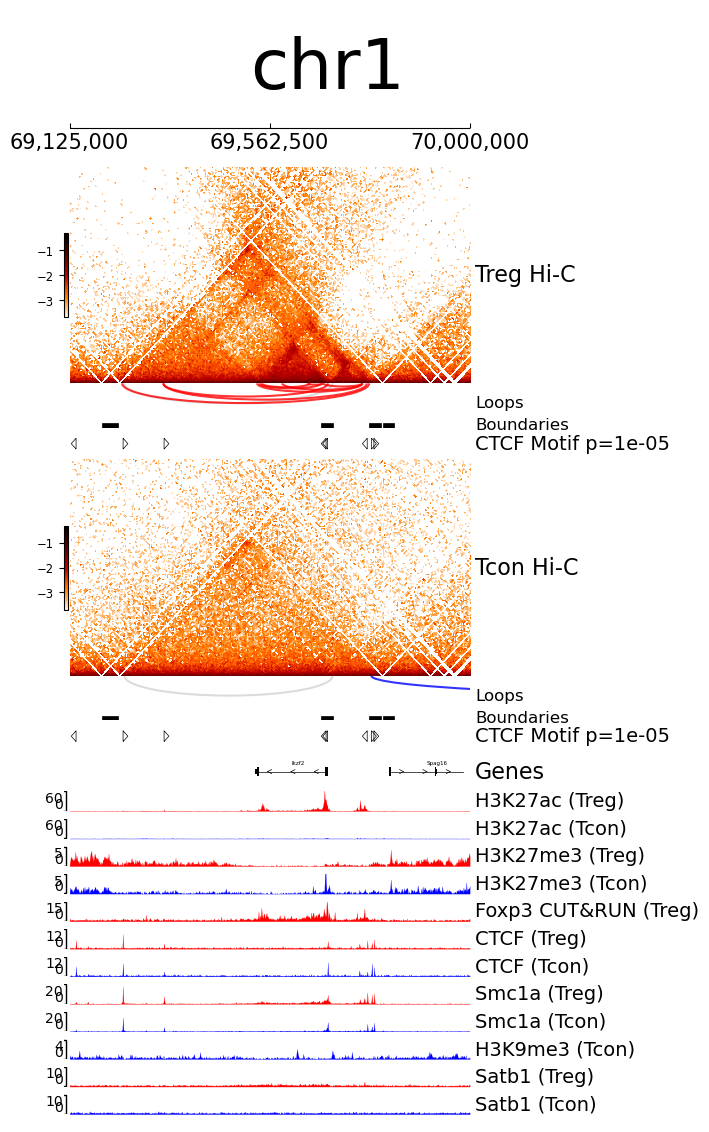

In [14]:
plt.rcParams.update({
    'patch.linewidth' : .35,
    'lines.linewidth' : .5,

})

f = make_coolbox_plot(i1=278, i2=278, d1=1.5, d2=1, depth_ratio=1,
                        xaxis_width = 15, cool_width = 12.5, hic_height = 4,
                      vmin = 2e-4, vmax=5e-1,
                     )
f


### Figure S3

[W::hts_idx_load3] The index file is older than the data file: ./FINAL_boundaries/all_boundaries.bed.bgz.tbi
[W::hts_idx_load3] The index file is older than the data file: peaks/motifs/all_ctcf_peaks_p=1e-05.txt.bgz.tbi
[W::hts_idx_load3] The index file is older than the data file: ./FINAL_boundaries/all_boundaries.bed.bgz.tbi
[W::hts_idx_load3] The index file is older than the data file: peaks/motifs/all_ctcf_peaks_p=1e-05.txt.bgz.tbi


45
file: /Genomics/argo/users/gdolsten/pritlab/jupys/tregs/pygbrowse/Mus_musculus.GRCm38.93.chr.gff3.gz.bgzf
[11125000, 11462500, 11800000]


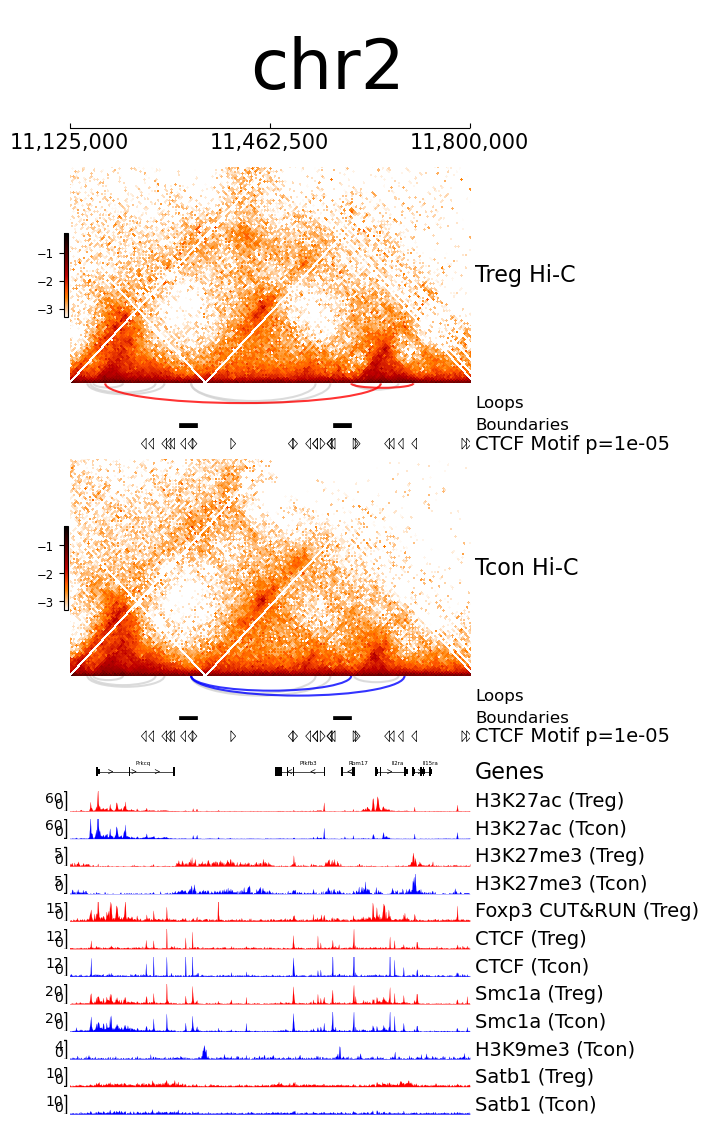

In [15]:
from plotting_functions import *
from plot_with_coolbox import *

f = make_coolbox_plot(i1=828, d1=1.5, d2=.2,
                     depth_ratio=1,
                     xaxis_width = 15, cool_width = 12.5, hic_height = 4,
                     gtf_ylim=[-1, 1],
                     )
plt.rcParams['pdf.fonttype'] = 42
f.savefig('./plots/paper/s4/IL2RA.pdf')
f

[W::hts_idx_load3] The index file is older than the data file: ./FINAL_boundaries/all_boundaries.bed.bgz.tbi
[W::hts_idx_load3] The index file is older than the data file: peaks/motifs/all_ctcf_peaks_p=1e-05.txt.bgz.tbi
[W::hts_idx_load3] The index file is older than the data file: ./FINAL_boundaries/all_boundaries.bed.bgz.tbi
[W::hts_idx_load3] The index file is older than the data file: peaks/motifs/all_ctcf_peaks_p=1e-05.txt.bgz.tbi


45
file: /Genomics/argo/users/gdolsten/pritlab/jupys/tregs/pygbrowse/Mus_musculus.GRCm38.93.chr.gff3.gz.bgzf
orphan transcript transcript:ENSMUST00000159347 with missing parent gene:ENSMUSG00000090126!
[28250000, 28650000, 29050000]


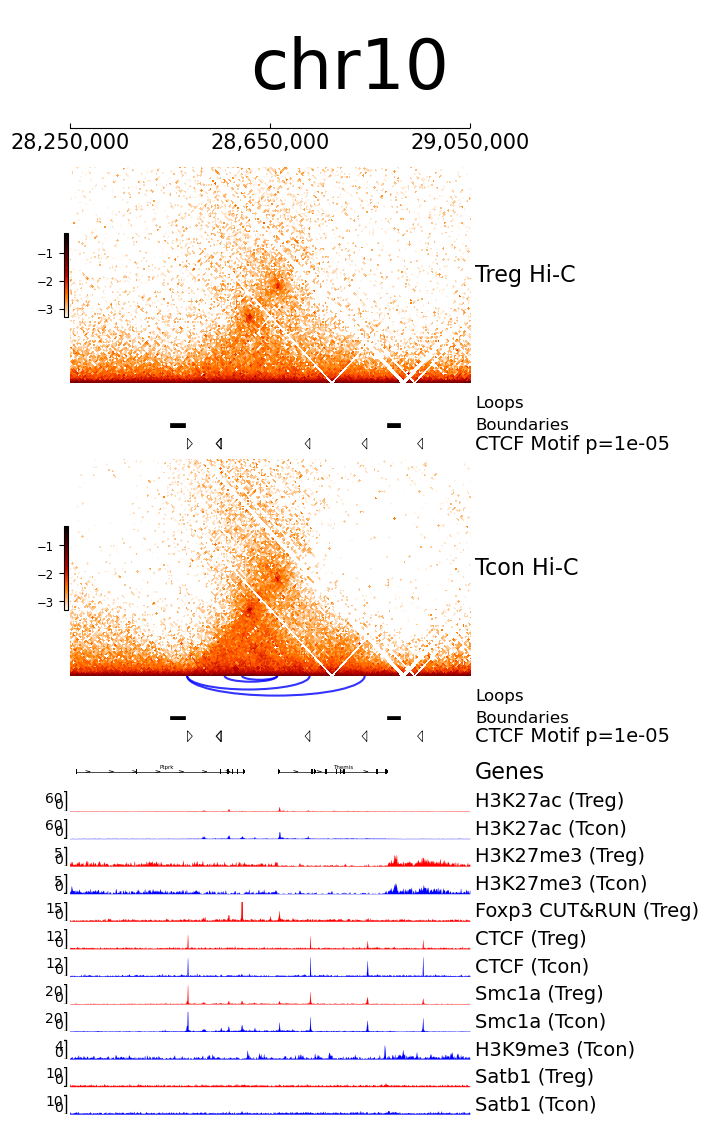

In [16]:
from plotting_functions import *
from plot_with_coolbox import *

f = make_coolbox_plot(i1=5700, d1=2, d2=.2,
                     depth_ratio=1,
                     xaxis_width = 15, cool_width = 12.5, hic_height = 4,
                     gtf_ylim=[-1, 1],
                     )
plt.rcParams['pdf.fonttype'] = 42
f.savefig('./plots/paper/s4/THEMIS.pdf')
f

[W::hts_idx_load3] The index file is older than the data file: ./FINAL_boundaries/all_boundaries.bed.bgz.tbi
[W::hts_idx_load3] The index file is older than the data file: peaks/motifs/all_ctcf_peaks_p=1e-05.txt.bgz.tbi
[W::hts_idx_load3] The index file is older than the data file: ./FINAL_boundaries/all_boundaries.bed.bgz.tbi
[W::hts_idx_load3] The index file is older than the data file: peaks/motifs/all_ctcf_peaks_p=1e-05.txt.bgz.tbi


45
file: /Genomics/argo/users/gdolsten/pritlab/jupys/tregs/pygbrowse/Mus_musculus.GRCm38.93.chr.gff3.gz.bgzf
[106750000, 107187500, 107625000]


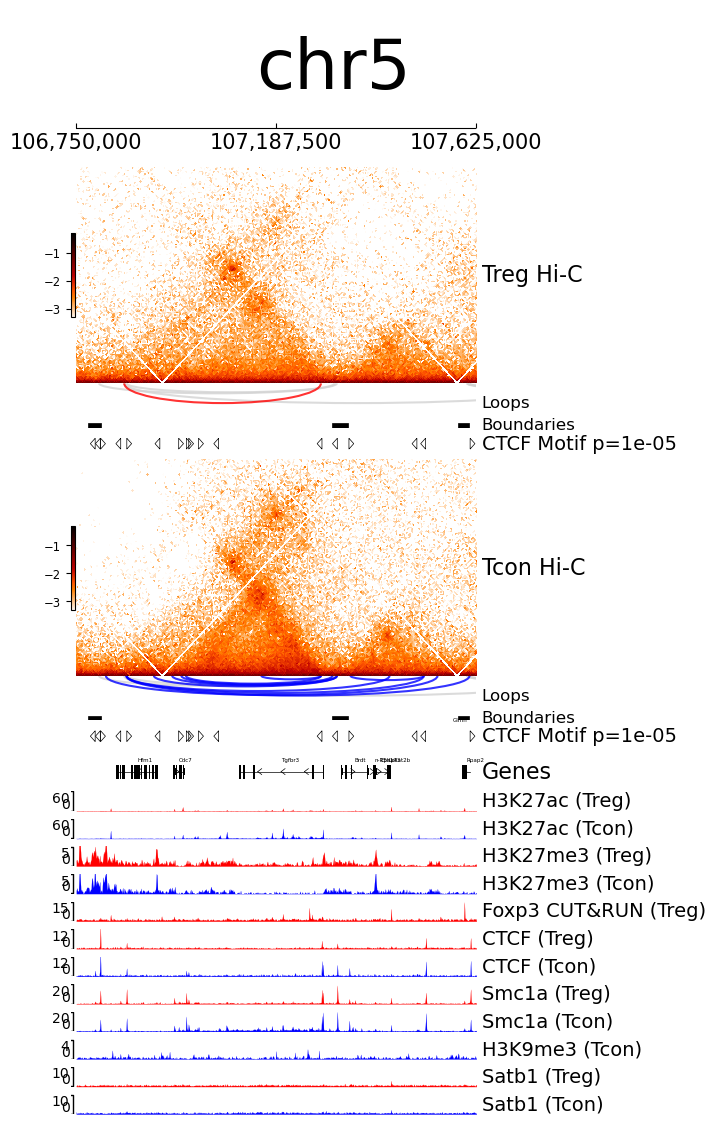

In [17]:
from plotting_functions import *
from plot_with_coolbox import *

f = make_coolbox_plot(i1=3208, d1=2, d2=.5,
                     depth_ratio=1,
                     xaxis_width = 15, cool_width = 12.5, hic_height = 4,
                     gtf_ylim=[-1, 1],
                     )
plt.rcParams['pdf.fonttype'] = 42
f.savefig('./plots/paper/s4/TGFBR3.pdf')
f

[W::hts_idx_load3] The index file is older than the data file: ./FINAL_boundaries/all_boundaries.bed.bgz.tbi
[W::hts_idx_load3] The index file is older than the data file: peaks/motifs/all_ctcf_peaks_p=1e-05.txt.bgz.tbi
[W::hts_idx_load3] The index file is older than the data file: ./FINAL_boundaries/all_boundaries.bed.bgz.tbi
[W::hts_idx_load3] The index file is older than the data file: peaks/motifs/all_ctcf_peaks_p=1e-05.txt.bgz.tbi


45
file: /Genomics/argo/users/gdolsten/pritlab/jupys/tregs/pygbrowse/Mus_musculus.GRCm38.93.chr.gff3.gz.bgzf
[98262500, 98625000, 98987500]


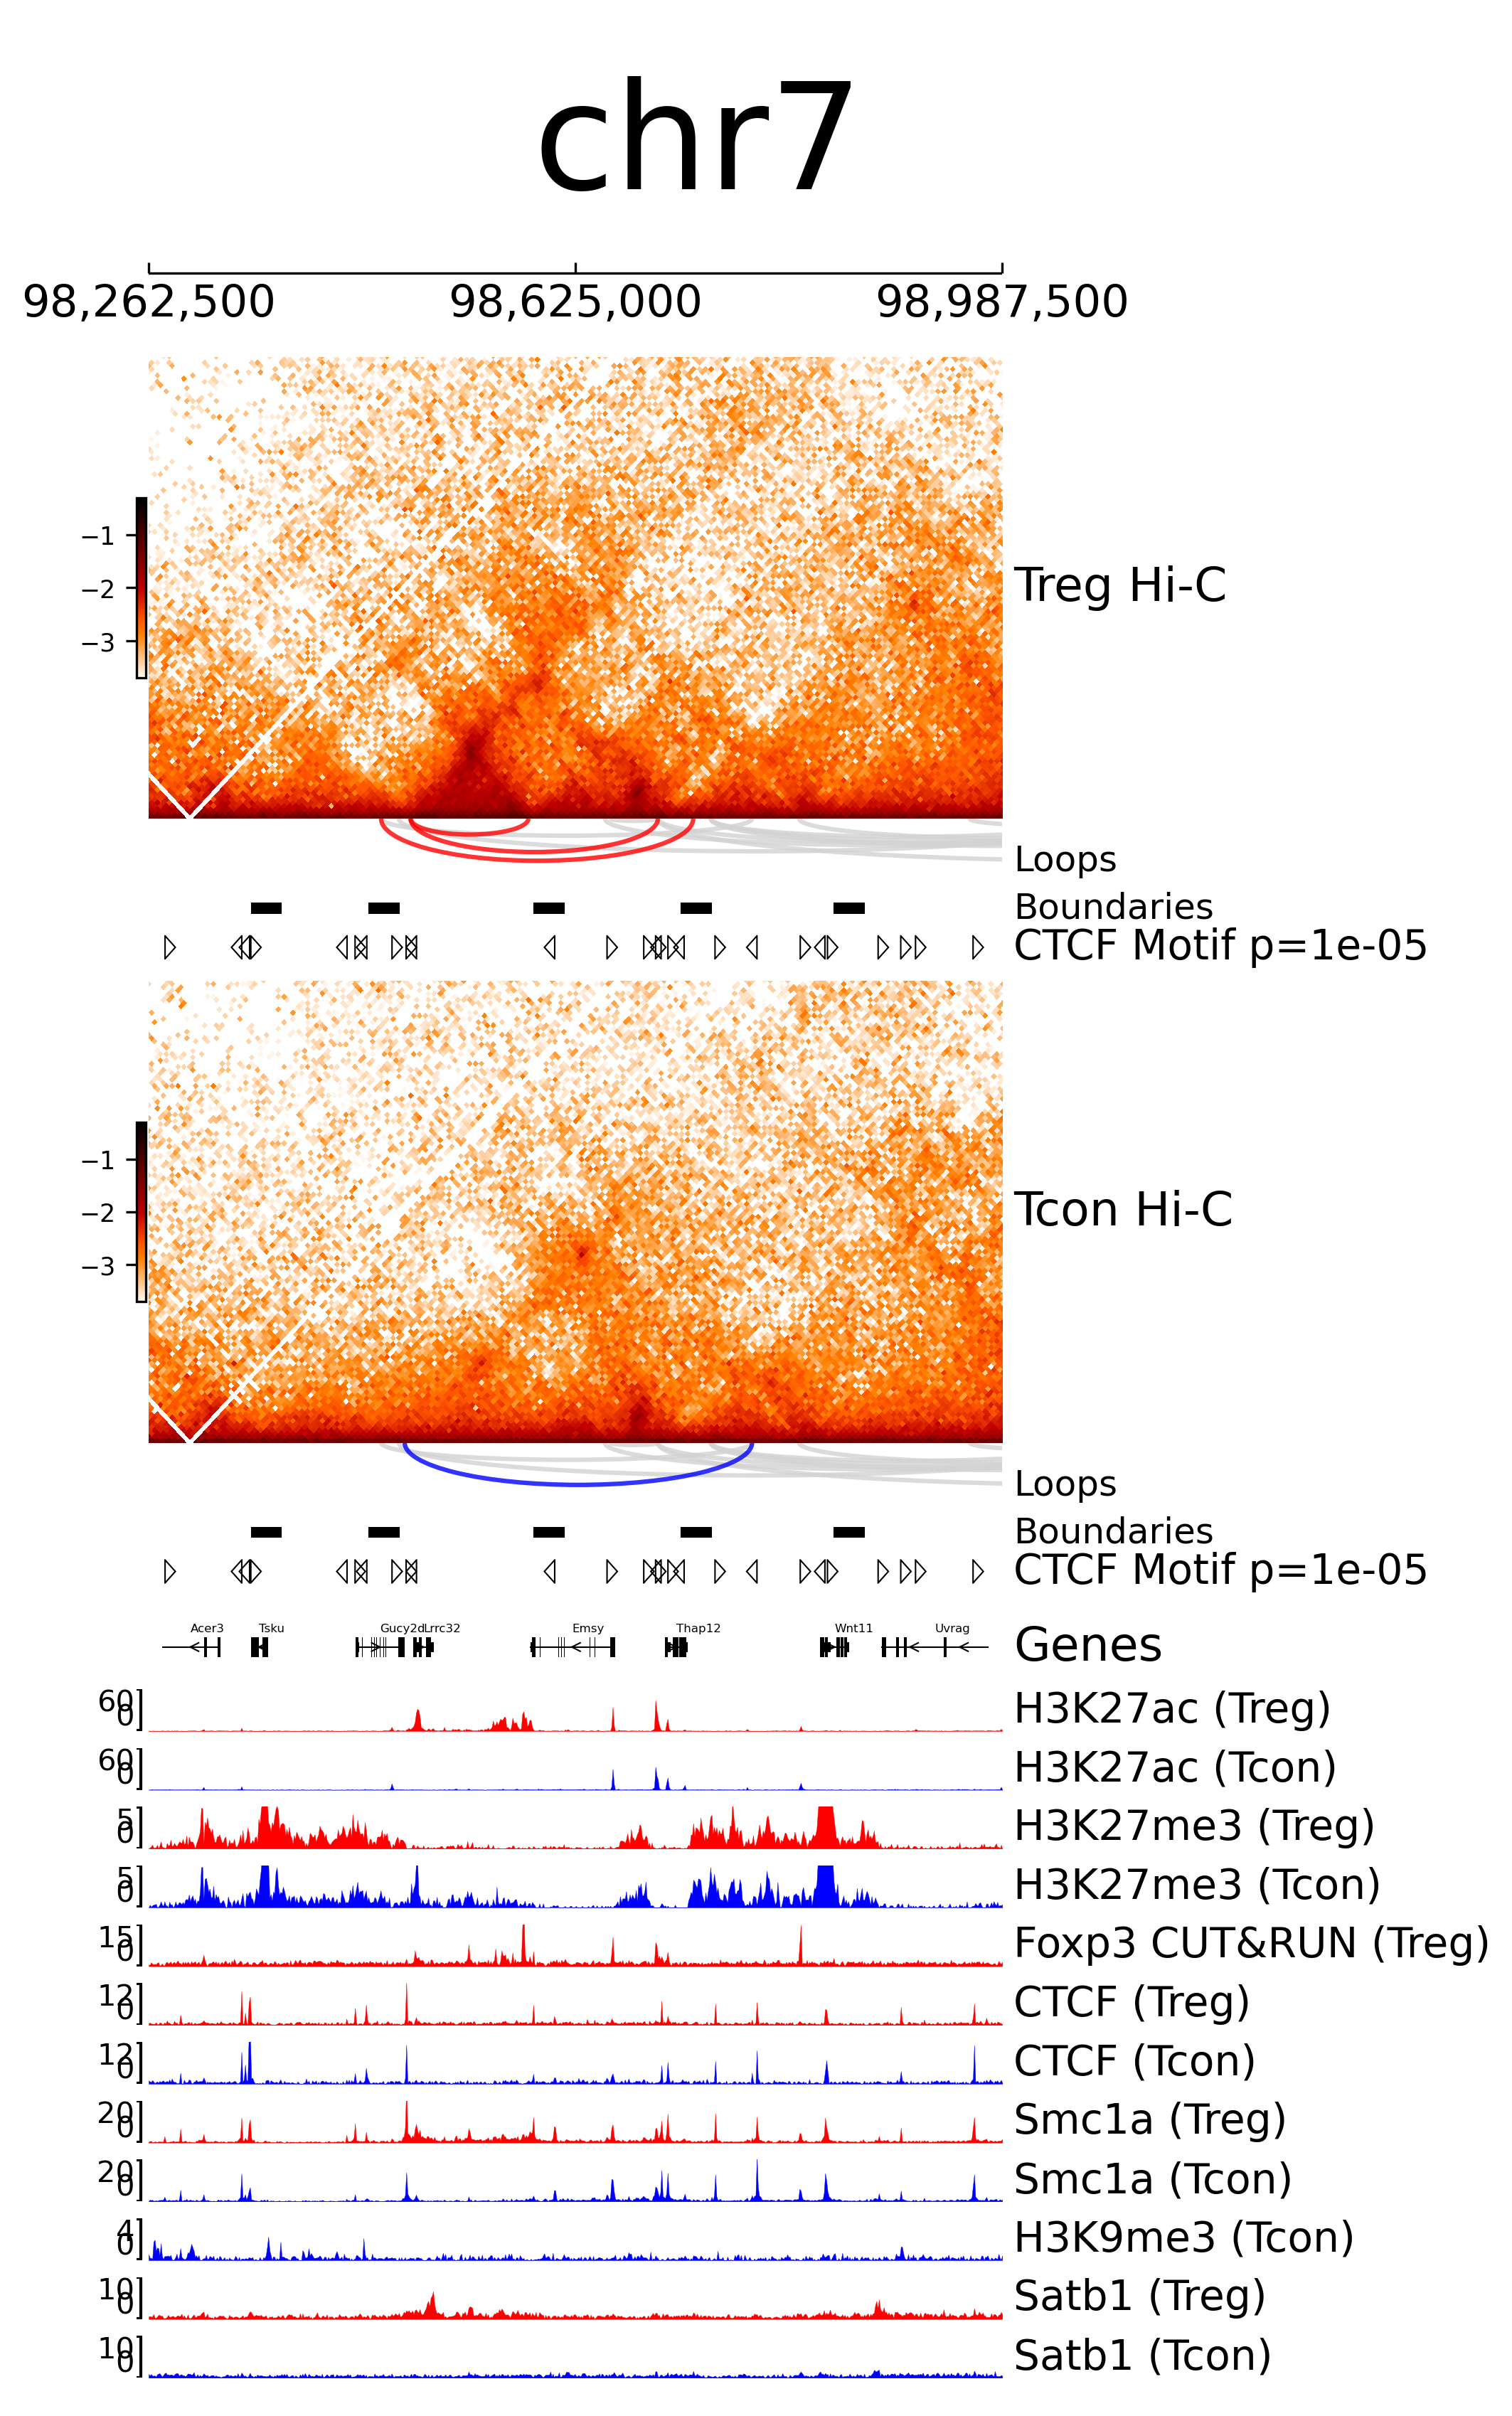

In [18]:
f = make_coolbox_plot(i1=4380, i2=4380, d1=.95, d2=.95,
                     depth_ratio=1,
                     xaxis_width = 15, cool_width = 12.5, hic_height = 4,
                     gtf_ylim=[-1, 1],
                      vmin = 2e-4, vmax=5e-1,
                     )
f.dpi=300
f.savefig('./plots/paper/s4/Lrrc32.pdf')
f

### Figure S18

[W::hts_idx_load3] The index file is older than the data file: ./FINAL_boundaries/all_boundaries.bed.bgz.tbi
[W::hts_idx_load3] The index file is older than the data file: peaks/motifs/all_ctcf_peaks_p=1e-05.txt.bgz.tbi
[W::hts_idx_load3] The index file is older than the data file: ./FINAL_boundaries/all_boundaries.bed.bgz.tbi
[W::hts_idx_load3] The index file is older than the data file: peaks/motifs/all_ctcf_peaks_p=1e-05.txt.bgz.tbi


45
file: /Genomics/argo/users/gdolsten/pritlab/jupys/tregs/pygbrowse/Mus_musculus.GRCm38.93.chr.gff3.gz.bgzf
[71125000, 71375000, 71625000]


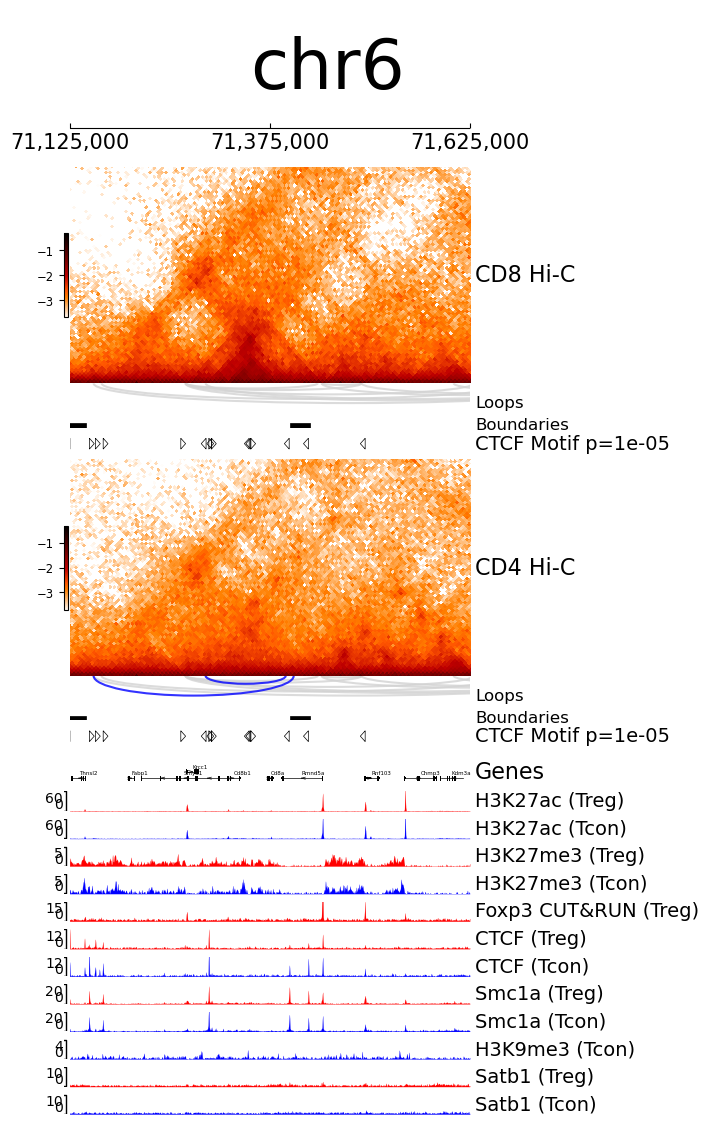

In [19]:
from plot_with_coolbox import *
import matplotlib.pyplot as plt


plt.rcParams.update({
    'patch.linewidth' : .35,
    'lines.linewidth' : .5,

})

f = make_coolbox_plot(i1=3672, i2=3672, d1=.5, d2=.5, depth_ratio=1,
                        xaxis_width = 15, cool_width = 12.5, 
                        hic_height = 4, vmin = 2e-4, vmax=5e-1,
                      treg_coolpath='/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/zoomified_merged_cools/CD8_ours_no_chrM.mcool',
                      tcon_coolpath='/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/zoomified_merged_cools/CD4_ours_no_chrM.mcool',
                      treg_label = 'CD8 Hi-C', tcon_label = 'CD4 Hi-C',
                      gtf_ylim=[-2, 4],
                     )
f.savefig('./plots/paper/s27/cd8_cd8cd4data.pdf', bbox_inches='tight')
f

[W::hts_idx_load3] The index file is older than the data file: ./FINAL_boundaries/all_boundaries.bed.bgz.tbi
[W::hts_idx_load3] The index file is older than the data file: peaks/motifs/all_ctcf_peaks_p=1e-05.txt.bgz.tbi
[W::hts_idx_load3] The index file is older than the data file: ./FINAL_boundaries/all_boundaries.bed.bgz.tbi
[W::hts_idx_load3] The index file is older than the data file: peaks/motifs/all_ctcf_peaks_p=1e-05.txt.bgz.tbi


45
file: /Genomics/argo/users/gdolsten/pritlab/jupys/tregs/pygbrowse/Mus_musculus.GRCm38.93.chr.gff3.gz.bgzf
[124750000, 124937500, 125125000]


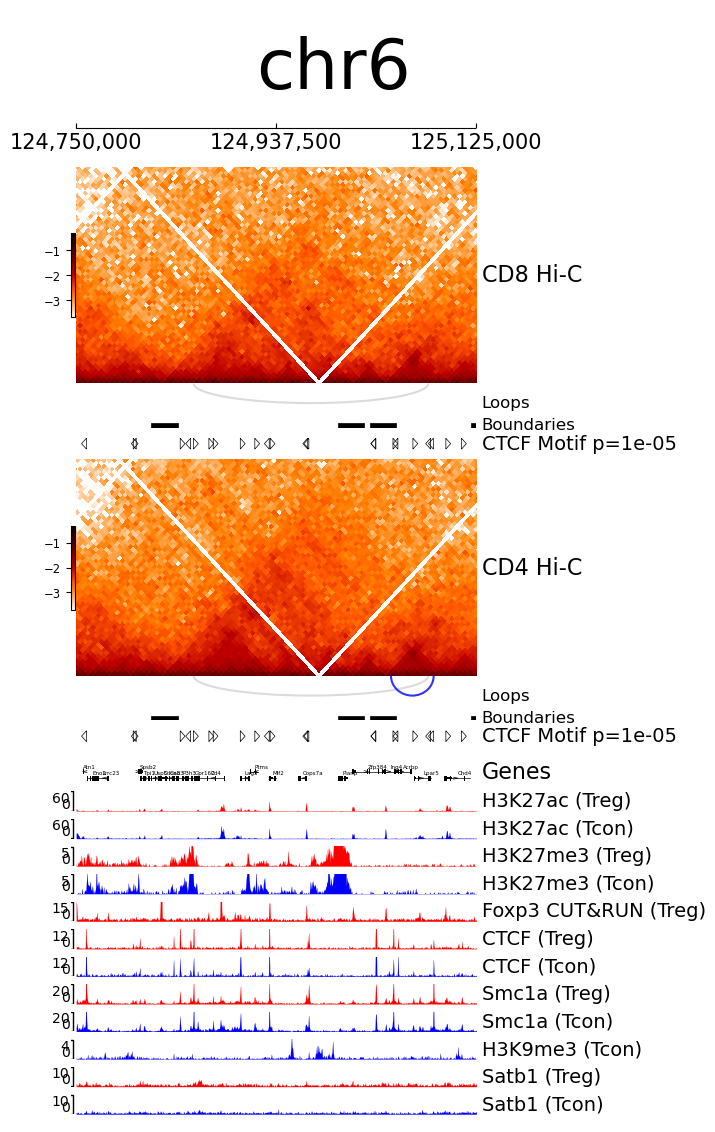

In [20]:
plt.rcParams.update({
    'patch.linewidth' : .35*0,
    'lines.linewidth' : .5,
})

f = make_coolbox_plot(i1=3886, i2=3886, d1=0, d2=.5, depth_ratio=1,
                        xaxis_width = 15, cool_width = 12.5, 
                        hic_height = 4, vmin = 2e-4, vmax=5e-1,
                      treg_coolpath='/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/zoomified_merged_cools/CD8_ours_no_chrM.mcool',
                      tcon_coolpath='/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/zoomified_merged_cools/CD4_ours_no_chrM.mcool',
                      treg_label = 'CD8 Hi-C', tcon_label = 'CD4 Hi-C',
                      gtf_ylim=[-2, 4],
                     )
f.savefig('./plots/paper/s27/cd4_cd8cd4data.pdf', bbox_inches='tight')
f